In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-05-15 19:09:33.121239: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 19:09:33.165069: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from keras import backend as K

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from sklearn.decomposition import PCA

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [7]:
rows,cols = x_train[0].shape
input_len = rows*cols
x_train = x_train.reshape(x_train.shape[0], input_len).astype('float32')/255
x_test = x_test.reshape(x_test.shape[0], input_len).astype('float32')/255

In [8]:
# PCA on MNIST

In [9]:
num_components = 100
model = PCA(n_components=num_components)
principal_components = model.fit_transform(x_train)
eigenvalues = model.explained_variance_

In [10]:
PCAj = model.explained_variance_ratio_
principal_axes = model.components_

In [11]:
pX = x_train @ principal_axes[:2,:].T

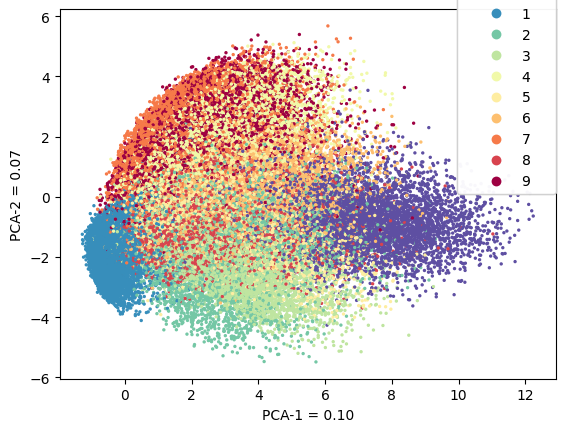

In [12]:
fig,ax = plt.subplots()
scatter = ax.scatter(pX[:,0],pX[:,1],s=2,c=y_train,cmap='Spectral_r')

legend = ax.legend(*scatter.legend_elements(),loc=(.8,.5), title="MNIST Digits")
ax.add_artist(legend)

ax.set_xlabel(f'PCA-1 = {PCAj[0]:.2f}')
ax.set_ylabel(f'PCA-2 = {PCAj[1]:.2f}');

In [13]:
# AUTOENCODER ON MNIST

In [14]:
autoencoder = keras.Sequential(
[
    keras.layers.Dense(100, input_shape = (784,), activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(2, activation='relu', name="middle"),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(784, activation='sigmoid')
])
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 middle (Dense)              (None, 2)                 22        
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_3 (Dense)             (None, 100)               1100      
                                                                 
 dense_4 (Dense)             (None, 784)               79184     
                                                                 
Total params: 159846 (624.40 KB)
Trainable params: 15984

In [15]:
batch_size = 70
epochs = 50
training_history = autoencoder.fit(x_train,x_train, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,x_test))

Epoch 1/50
858/858 [==============================] - 3s 3ms/step - loss: 0.0703 - accuracy: 0.0115 - val_loss: 0.0632 - val_accuracy: 0.0108
Epoch 2/50
858/858 [==============================] - 2s 3ms/step - loss: 0.0613 - accuracy: 0.0111 - val_loss: 0.0596 - val_accuracy: 0.0148
Epoch 3/50
858/858 [==============================] - 2s 3ms/step - loss: 0.0581 - accuracy: 0.0104 - val_loss: 0.0571 - val_accuracy: 0.0086
Epoch 4/50
858/858 [==============================] - 2s 2ms/step - loss: 0.0560 - accuracy: 0.0095 - val_loss: 0.0549 - val_accuracy: 0.0103
Epoch 5/50
858/858 [==============================] - 2s 2ms/step - loss: 0.0544 - accuracy: 0.0099 - val_loss: 0.0530 - val_accuracy: 0.0102
Epoch 6/50
858/858 [==============================] - 2s 2ms/step - loss: 0.0490 - accuracy: 0.0087 - val_loss: 0.0473 - val_accuracy: 0.0078
Epoch 7/50
858/858 [==============================] - 2s 2ms/step - loss: 0.0465 - accuracy: 0.0098 - val_loss: 0.0461 - val_accuracy: 0.0121
Epoch 

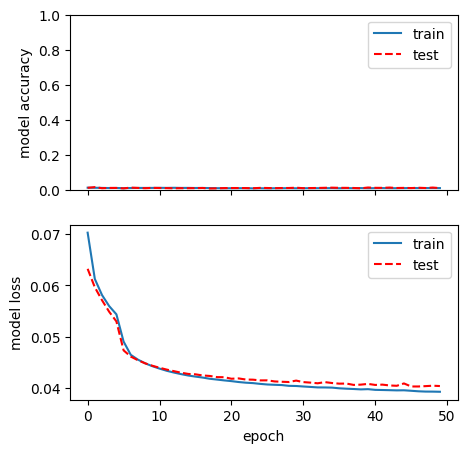

In [16]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

In [17]:
inner_neuron = keras.Model(
  inputs=autoencoder.input,
  outputs=autoencoder.get_layer("middle").output)

inner_output = np.array(inner_neuron(x_test))


In [18]:
first_component = inner_output[::,0]
second_component = inner_output[::,1]

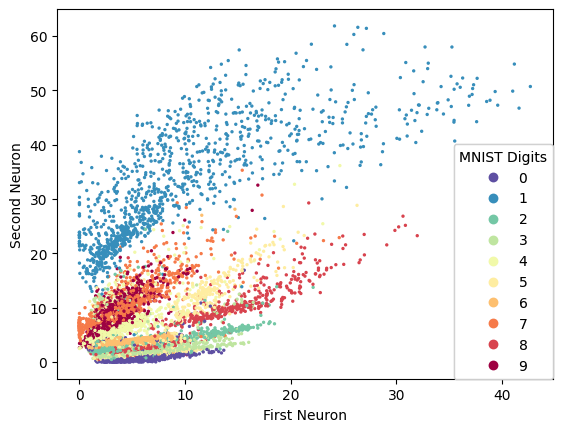

In [19]:
fig,ax = plt.subplots()
scatter = ax.scatter(first_component,second_component,s=2,c=y_test,cmap='Spectral_r')

legend = ax.legend(*scatter.legend_elements(),loc=(.8,0), title="MNIST Digits")
ax.add_artist(legend)

ax.set_xlabel('First Neuron')
ax.set_ylabel('Second Neuron')
plt.show()

In [20]:
def multidisplay(inputs,  num_cols = 10):
    n = len(inputs)
    num_rows = int(np.ceil(n/num_cols))
    
    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols,sharex=True,sharey=True,
                          figsize=(num_cols,num_rows))
    for i,cax in enumerate(ax.flatten()):
        if i < n:
            cax.imshow(inputs[i].reshape(28, 28),cmap='gray')

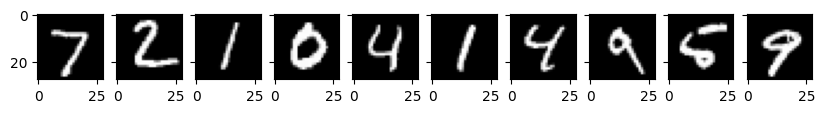

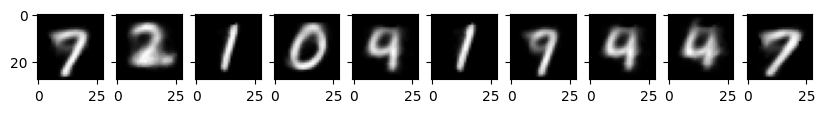

In [40]:
multidisplay(x_test[:10])
multidisplay(np.array(autoencoder(x_test[:10])))

In [22]:
# VAE on MNIST

In [23]:
# Input dimensions
input_dim = input_len

# Latent space dimension
latent_dim = 2

# List of input layers 
layer_list = [(100,'relu'), (20,'relu')]


inputs = keras.Input(shape=(input_dim,))
layer = []
previous_layer = inputs
for i, (dim, activ) in enumerate(layer_list):
    layer = layers.Dense(dim, activation=activ, name = f'Dense_{i+1}')(previous_layer)
    previous_layer = layer
z_mean = layers.Dense(latent_dim, name = 'z_mean')(layer)
z_log_sigma = layers.Dense(latent_dim, name = 'z_log_sigma')(layer)

In [24]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [25]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 Dense_1 (Dense)             (None, 100)                  78500     ['input_1[0][0]']             
                                                                                                  
 Dense_2 (Dense)             (None, 20)                   2020      ['Dense_1[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 2)                    42        ['Dense_2[0][0]']             
                                                                                            

In [26]:
# Making decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
previous_layer = latent_inputs

for i, (dim, activ) in enumerate(layer_list[::-1]):
    layer = layers.Dense(dim, activation=activ, name = f'Dense_{i+1+len(layer_list)}')(previous_layer)
    previous_layer = layer

outputs = layers.Dense(input_dim, activation='sigmoid')(layer)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 Dense_3 (Dense)             (None, 20)                60        
                                                                 
 Dense_4 (Dense)             (None, 100)               2100      
                                                                 
 dense_5 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81344 (317.75 KB)
Trainable params: 81344 (317.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Make VAE
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='VAE')

In [28]:
# making loss function
reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['accuracy'])

In [29]:
epochs = 50

training_history = vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(x_test, x_test), verbose = 1)

Epoch 1/50
1875/1875 [==============================] - 5s 2ms/step - loss: 44.5577 - accuracy: 0.0120 - val_loss: 38.7855 - val_accuracy: 0.0129
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 37.9784 - accuracy: 0.0149 - val_loss: 36.9420 - val_accuracy: 0.0107
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 36.5283 - accuracy: 0.0117 - val_loss: 35.6474 - val_accuracy: 0.0111
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 35.5007 - accuracy: 0.0113 - val_loss: 34.9658 - val_accuracy: 0.0076
Epoch 5/50
1875/1875 [==============================] - 4s 2ms/step - loss: 34.8035 - accuracy: 0.0107 - val_loss: 34.3717 - val_accuracy: 0.0103
Epoch 6/50
1875/1875 [==============================] - 4s 2ms/step - loss: 34.2720 - accuracy: 0.0100 - val_loss: 33.9250 - val_accuracy: 0.0087
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 33.8220 - accuracy: 0.0093 - val_loss: 33.5215 -

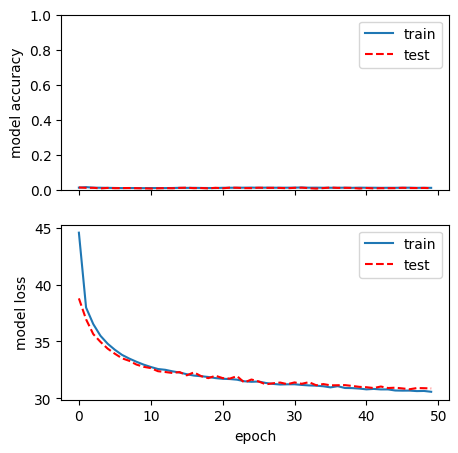

In [30]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history.history['accuracy'])
ax[0].plot(training_history.history['val_accuracy'], ls='--', color="red")
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history.history['loss'])
ax[1].plot(training_history.history['val_loss'], ls='--', color="red")
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');
#ax[1].set_ylim(0,.1)

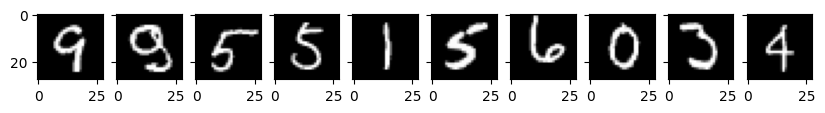

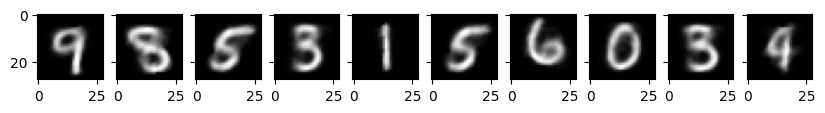

In [31]:
goofy = 150
multidisplay(x_test[goofy:goofy+10])
multidisplay(np.array(vae(x_test[goofy:goofy+10])))

In [32]:
# Generating new digits

In [33]:

n = 5
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

digits = []
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0]
        digits.append([digit])

1/1 [==============================] - 0s 13ms/step


In [34]:
digits = np.squeeze(digits)

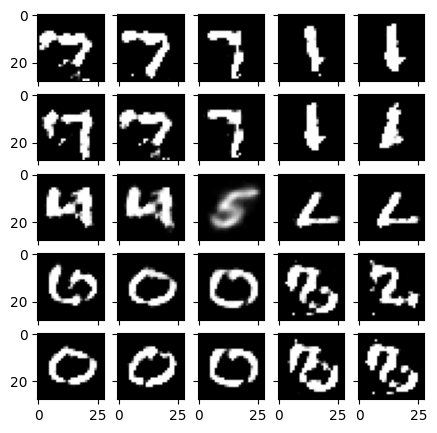

In [35]:
multidisplay(digits, 5)

In [36]:
encoded = encoder.predict(x_test, batch_size=batch_size)[2]

143/143 [==============================] - 0s 825us/step


In [37]:
np.min(encoded[:,0]), np.max(encoded[:,0])

(-2.6115274, 2.433897)

In [38]:
n = 9
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

digits = []
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0]
        digits.append([digit])

1/1 [==============================] - 0s 14ms/step


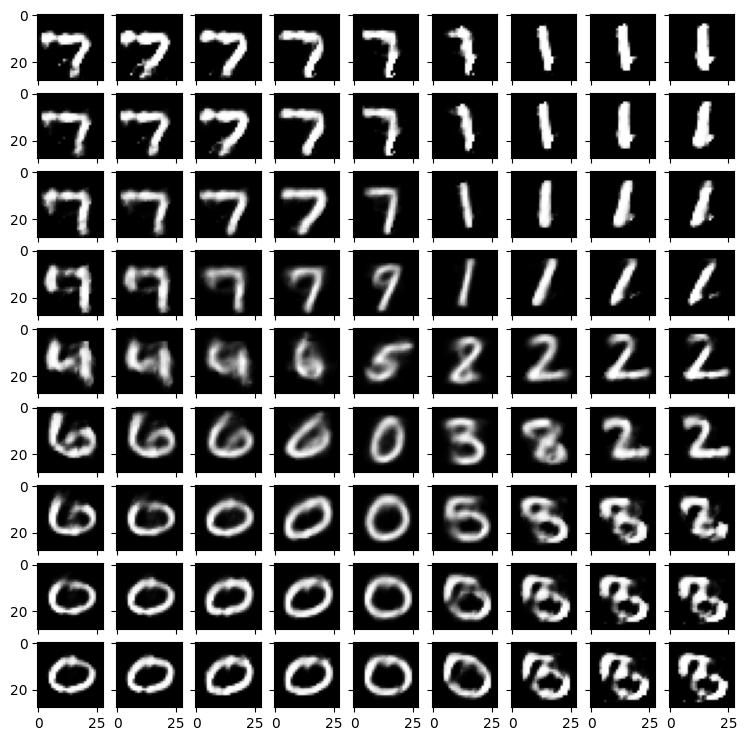

In [39]:
digits = np.squeeze(digits)
multidisplay(digits, 9)